In [219]:
import jax
import jax.numpy as jnp
import equinox as eqx
import qutip as qu
from jax import jit, vmap
import numpy as np
from jax.scipy.linalg import expm
import matplotlib.pyplot as plt

In [172]:
def dag(A):
    return jnp.conjugate(A.T)


def sprepost(A, B):
    return jnp.kron(B.T, A)


def spre(A):
    return sprepost(A, jnp.identity(2))


def spost(A):
    return sprepost(jnp.identity(2), A)


def vec(A):
    return A.flatten("F")

In [180]:
delta = 0.12739334807998307
Omega = 0.5
gnot = 0
gp = 2 * 0.179165
gn = 2 * 0.157108
Snot = -0.12739334807998307
Sp = -0.333695
Sn = 0.053851
true_pars = jnp.array([gn, gp, Sn, Sp])

In [243]:
def get_SIC_POVM_4D():
    x = np.sqrt(2 + np.sqrt(5))

    sic_arr = np.array(
        [
            [x, 1, 1, 1],
            [x, 1, -1, -1],
            [x, -1, 1, -1],
            [x, -1, -1, 1],
            [1j, x, 1, -1j],
            [1j, x, -1, 1j],
            [-1j, x, 1, 1j],
            [-1j, x, -1, -1j],
            [1j, 1j, x, -1],
            [1j, -1j, x, 1],
            [-1j, 1j, x, 1],
            [-1j, -1j, x, -1],
            [1j, 1, -1j, x],
            [1j, -1, 1j, x],
            [-1j, 1, 1j, x],
            [-1j, -1, -1j, x],
        ]
    ) / (np.sqrt(5 + np.sqrt(5)))

    sic_povm_set = []
    for i in range(sic_arr.shape[0]):
        sic_povm_set.append(np.outer(sic_arr[i].T, np.conjugate(sic_arr[i])) / 4)

    return jnp.array(sic_povm_set)


@jit
def evolve_basis(t, L, element):
    # Ltimest = np.einsum("i, jk", times, np.array(Liouvillian_ebasis))
    return (expm(t * L) @ element).reshape((2, 2), order="F")


@jit
def construct_choi_state(basis_elements, evolved_basis_elements):
    suma = 0
    for i in range(evolved_basis_elements.shape[0]):
        suma = suma + jnp.kron(basis_elements[i], evolved_basis_elements[i])
    return suma


@jit
def compute_P_singleop(evolved_choi, POVM):
    return jnp.real(jnp.trace(evolved_choi @ POVM))

In [300]:
class physical_model(eqx.Module):
    number_of_parameters: int
    delta: float
    Omega: float
    H0: jax.Array
    A: jax.Array
    sic_POVM_arr: jax.Array
    basis_elements: jax.Array
    # true_parameters: jax.Array

    def __init__(self):
        self.number_of_parameters = 4
        self.delta = 0.12739334807998307
        self.Omega = 0.5
        self.H0 = self.make_H0()
        self.A = jnp.array([[1, 0], [0, 0]])
        self.sic_POVM_arr = get_SIC_POVM_4D()
        self.basis_elements = jnp.identity(4)

    @jit
    def make_H0(self):
        return jnp.array([[self.delta, self.Omega / 2], [self.Omega / 2, 0]])

    @jit
    def make_liouvillian(self, particle):
        gn, gp, Sn, Sp = particle
        Snot = -self.delta
        gnot = 0

        U = jnp.linalg.eigh(self.H0)[1]
        Aij = U @ self.A @ dag(U)
        Cp = 0.5 * gp + 1j * Sp
        Cn = 0.5 * gn + 1j * Sn
        Cnot = 0.5 * gnot + 1j * Snot

        Gamma = jnp.array([[Cnot, Cn], [Cp, Cnot]])

        sqrtgamma = jnp.sqrt(jnp.real(Gamma))

        L = jnp.multiply(Aij, sqrtgamma)

        Af = jnp.multiply(Aij, jnp.conjugate(Gamma))
        Hrenorm = -1j / 2 * (Aij @ dag(Af) - Af @ dag(Aij))

        Htotal = U @ self.H0 @ dag(U) + Hrenorm
        Liouvillian_ebasis = (
            -1j * (spre(Htotal) - spost(Htotal))
            + sprepost(dag(L), L)
            - 0.5 * (spre(L @ dag(L)) + spost(L @ dag(L)))
        )
        return sprepost(U, dag(U)) @ Liouvillian_ebasis @ dag(sprepost(U, dag(U)))

    @jit
    def generate_choi(self, particle, t):
        L = self.make_liouvillian(particle)

        evolved_basis_array = vmap(evolve_basis, (None, None, 0))(
            t,
            L,
            self.basis_elements,
        )

        return (
            construct_choi_state(
                self.basis_elements.reshape(-1, 2, 2, order="F"), evolved_basis_array
            )
            / 2
        )

    @jit
    def likelihood_particle(self, particle, t):
        choi_state = self.generate_choi(particle, t)
        return jax.vmap(compute_P_singleop, in_axes=(None, 0))(
            choi_state, self.sic_POVM_arr
        )

    @jit
    def fim(self, particle, t):
        jacobian = jax.jacobian(self.likelihood_particle, 0)(particle, t)
        lkl = self.likelihood_particle(particle, t)
        return jnp.einsum("ij, ik, i -> jk", jacobian, jacobian, 1 / lkl)

    @jit
    def generate_data(self, key, true_particle, t):
        probabilities = self.likelihood_particle(true_particle, t)
        probabilities = probabilities / probabilities.sum()
        no_of_outcomes = self.sic_POVM_arr.shape[0]
        outcome = jax.random.choice(key, a=jnp.arange(no_of_outcomes), p=probabilities)
        return outcome

In [293]:
key = jax.random.PRNGKey(seed=1)

In [305]:
model_example = physical_model()
# model_example.likelihood_particle(true_pars, 0.4)
# jax.jacobian(model_example.likelihood_particle, 0)(true_pars, 0.4)

subkeys = jax.random.split(key, 11)
key, subkeys = subkeys[0], subkeys[1:]
jax.vmap(model_example.generate_data, in_axes=(0, None, None))(subkeys, true_pars, 1)

Array([ 4, 15,  3,  8, 13, 12,  3,  5,  5,  0], dtype=int32)

In [306]:
@jit
def likelihood_data(lkl_results, result):
    return lkl_results[result]

In [308]:
likelihood_data(model_example.likelihood_particle(true_pars, 0.4), model_example.generate_data(subkeys[0], true_pars, 0.4))

Array(0.00222445, dtype=float32)

In [310]:



f = jax.jit(jax.vmap(model_example.fim, in_axes=(None, 0)))



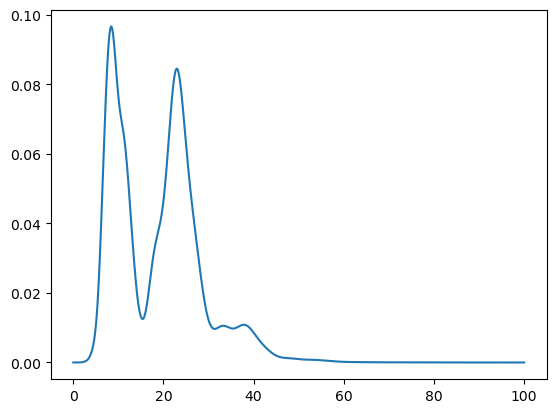

In [313]:
times = jnp.linspace(0.00001, 100, 5000)

fim_times = f(true_pars, times)
plt.plot(times, jnp.linalg.det(fim_times))